In [1]:
import re
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
columns = [u'cm_key', u'mvar2', u'mvar3', u'mvar4', u'mvar5', u'mvar6', u'mvar7', u'mvar8', u'mvar9', u'mvar10',
           u'mvar11', u'mvar12', u'mvar13', u'mvar14', u'mvar15', u'mvar16', u'mvar17', u'mvar18', u'mvar19', u'mvar20',
           u'mvar21', u'mvar22', u'mvar23', u'mvar24', u'mvar25', u'mvar26', u'mvar27', u'mvar28', u'mvar29', u'mvar30',
           u'mvar31', u'mvar32', u'mvar33', u'mvar34', u'mvar35', u'mvar36', u'mvar37', u'mvar38', u'mvar39', u'mvar40',
           u'mvar41', u'mvar42', u'mvar43', u'mvar44', u'mvar45', u'income_by_spending', u'membership_by_n',
           u'avg_electronics', u'avg_travel', u'avg_household', u'avg_car', u'avg_retailer', u'months_by_card',
           u'avg_quater1', u'avg_quater2', u'avg_quater3', u'avg_quater4', 
           # u'accepted_by_extended_supp',u'accepted_by_extended_elite', u'accepted_by_extended_credit', 
           u'avg_total', u'avg_sectors_quaters',
           u'other_spend_quater1_by_total', u'other_spend_quater2_by_total', u'other_spend_quater3_by_total',
           u'other_spend_quater4_by_total', u'other_spend_by_total', u'membership_by_income',u'spending_by_income',
           u'income_by_family', u'spending_by_family', u'membership_by_family'

]
quantity_features = [
                    u'mvar3', u'mvar6', u'mvar9', u'mvar16', u'mvar17', u'mvar18', u'mvar19', u'mvar20',
                    u'mvar21', u'mvar22', u'mvar23', u'mvar24', u'mvar25', u'mvar26', u'mvar27', u'mvar28', u'mvar29', 
                    u'mvar30', u'mvar31', u'mvar32', u'mvar33', u'mvar34', u'mvar35', u'mvar36', u'mvar37', u'mvar38', 
                    u'mvar39', u'avg_electronics', u'avg_travel', u'avg_household', u'avg_car', u'avg_retailer',
                    u'avg_quater1', u'avg_quater2', u'avg_quater3', u'avg_quater4', u'avg_total', u'avg_sectors_quaters',
                    u'income_by_family', u'spending_by_family', u'membership_by_family'
]
ratio_features = [
                u'mvar7', u'mvar8', u'mvar11',
                u'other_spend_quater1_by_total', u'other_spend_quater2_by_total', u'other_spend_quater3_by_total',
                u'other_spend_quater4_by_total', u'other_spend_by_total', u'months_by_card', 
                # u'accepted_by_extended_supp', u'accepted_by_extended_elite', u'accepted_by_extended_credit', 
                u'income_by_spending', u'membership_by_n',u'membership_by_income',u'spending_by_income'
]
number_features = [
                 u'mvar13', u'mvar14', u'mvar15', u'mvar2', u'mvar4', u'mvar5', u'mvar40',
                 u'mvar41', u'mvar42', u'mvar43', u'mvar44', u'mvar45'
]

categorical_columns = [u'mvar12', u'mvar10']
labels = pd.Series(train.target.values)
train = train[columns]
test = test[columns]

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for feature in categorical_columns:
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.fit_transform(test[feature])
ltr = len(train)
test_key = test.cm_key
data = pd.concat([train, test], axis = 0)
data.drop(['cm_key'], axis = 1, inplace = True)
del train
del test

# Transform the skewed numeric features by taking log(feature + 1).
# This will make the features more normal.
# from scipy.stats import skew
# skewed = data[quantity_features].apply(lambda x: skew(x.dropna().astype(float)))
# skewed = skewed[skewed > 0.75]
# skewed = skewed.index
# data[skewed] = np.log1p(data[skewed])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[quantity_features])
scaled = scaler.transform(data[quantity_features])
for i, col in enumerate(quantity_features):
    data[col] = scaled[:,i]

train_data_df = data[:ltr]
test_data_df = data[ltr:]

del data

In [5]:
def printtofile(df, PROBABILITY_THRESHOLD):
    df.drop('0',1, inplace=True)
    filtr = lambda x: 1 if x > PROBABILITY_THRESHOLD else 0
    df['Credit'] = df['1'].apply(filtr)
    df['Elite'] = df['2'].apply(filtr)
    df['Supp'] = df['3'].apply(filtr)
    print df[['Credit', 'Elite', 'Supp']].values.sum()
    df['prob'] = df['1']*df['Credit'] + df['2']*df['Elite'] + df['3']*df['Supp']
    df['cm_key'] = range(50001, 50001+len(df))
    df.sort_values(['prob'], ascending=[False], inplace=True)
    df.drop(['1', '2', '3'],1, inplace=True)
    df['label_type'] = 6*df['Credit'] + 8*df['Elite'] + 10*df['Supp']
    lbl = lambda x: 'Credit' if x == 6 else ('Elite' if x == 8 else ('Supp' if x == 10 else 'Credit'))
    df['label'] = df['label_type'].apply(lbl)
    df.to_csv("results_xgb.csv", index=False)

#### STEP 0 : Keep learning rate and Number of estimators constant and run the inital model with any set of parameters 

In [ ]:
n_fold = 5
tree = 'gbtree'
seed = 27
thread = 4
imbalanced = 1
num_class = 4
obj = 'multi:softprob'
early_stopping_rounds = 50
import xgboost as xgb #this is the direct xgboost library. I will use a specific function “cv” from this library
from xgboost.sklearn import XGBClassifier #this is an sklearn wrapper for XGBoost. 
#Note that xgboost’s sklearn wrapper doesn’t have a “feature_importances” metric but a get_fscore() function which does the same job.
param = {}
param['eta'] = 0.01
param['gamma'] = 0.1 #Default value is zero... shall be trained
param['max_depth'] = 20
param['min_child_weight'] = 1
param['subsample'] = 0.9
param['colsample_bytree '] = 0.7
param['lambda']=0.1 #Default is zero
# param['booster']= tree
param['nthread'] = thread
param['scale_pos_weight'] = imbalanced
param['seed'] = seed
param['objective'] = obj
param['num_class'] = num_class
xgb_tr = xgb.DMatrix(train_data_df, label=labels, missing=np.NaN)
INITIAL_MODEL = xgb.train(param, xgb_tr, 
                          num_boost_round = 1800, 
                          verbose_eval=1)

/home/innovationchef/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


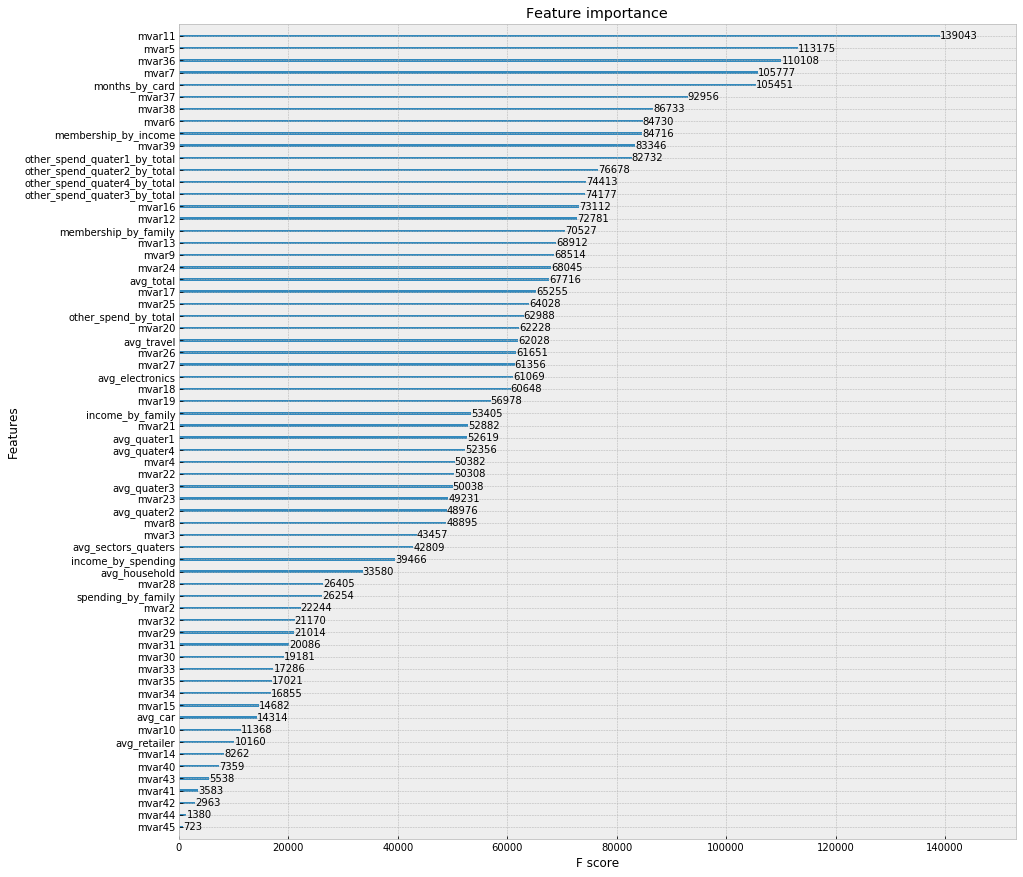

In [6]:
imp = xgb.plot_importance(INITIAL_MODEL, title='Feature importance', xlabel='F score', ylabel='Features')
figure = imp.figure
figure.set_size_inches(15, 15)
# This will tell us which features were most important in the series of trees.

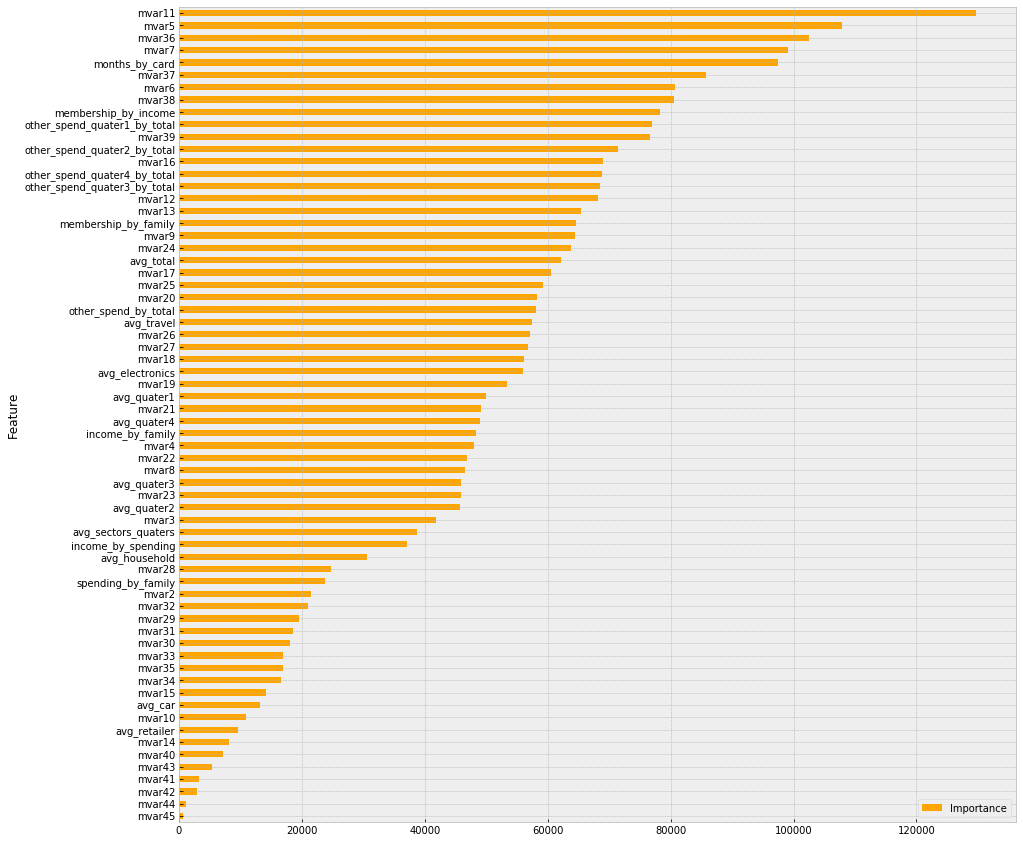

In [23]:
importances = INITIAL_MODEL.get_fscore()
# importances # It is a dict, you can print it too
# If the built-in feature importance method isn't what you wanted, 
# you can make your own chart of feature importances using the get_fscore method:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (15,15), color = 'orange')

In [9]:
xgb_ts = xgb.DMatrix(test_data_df, missing=np.NaN)
from sklearn.metrics import accuracy_score
y_pred = INITIAL_MODEL.predict(xgb_ts) # Predict using our testdmat
submission = pd.DataFrame(y_pred, columns=['0','1','2','3'])
submission.to_csv("raw_xgboost.csv")
printtofile(submission,0.15)

997


#### STEP 1 : Tune max_depth [4,5,6] and min_child_weight [4,5,6]

#### STEP 2 : Tune Gamma -> 0,0.1,0.2,0.3,0.4,0.5

#### STEP 3 : Tune Subsample [0.6,0.7,0.8,0.9,1.0] and colsample_bytree [0.6,0.7,0.8,0.9,1.0]

#### STEP 4 : Tune Regularization Parameters 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] or [0, 0.001, 0.005, 0.01, 0.05]

#### STEP 5 : Reduce Learning Rate

#### STEP 6 : Tune Early Stopping Rounds

In [8]:
import xgboost as xgb
early_stopping_rounds = 50
cv_folds = 5
ev_metric = 'mlogloss'
num_boost_round = 2500

param = {}
param['eta'] = 0.01
param['gamma'] = 0.01 #Default value is zero... shall be trained
param['max_depth'] = 5
param['min_child_weight'] = 5
param['subsample'] = 0.6
param['colsample_bytree '] = 0.6
param['lambda']= 0.01 #Default is zero
param['silent'] = 0  #Default is zero
param['nthread'] = 4
param['scale_pos_weight'] = 1 # Set 1 in case of imbalanced Dataset
param['seed'] = 27
param['objective'] = 'multi:softprob' 
param['num_class'] = 4 #required when obj is 'multi:softmax'

xgb_tr = xgb.DMatrix(train_data_df, label=labels, missing=np.NaN)
cvresult = xgb.cv(params = param, 
                  dtrain = xgb_tr, 
                  stratified = True,
                  num_boost_round = num_boost_round, 
                  nfold = cv_folds,
                  metrics = ev_metric, 
                  verbose_eval = 1) 

[0]	train-mlogloss:1.37568+1.75682e-05	test-mlogloss:1.37578+4.52433e-05
[1]	train-mlogloss:1.36528+3.16645e-05	test-mlogloss:1.36549+7.64471e-05
[2]	train-mlogloss:1.35507+4.7462e-05	test-mlogloss:1.35538+9.78162e-05
[3]	train-mlogloss:1.34506+4.09214e-05	test-mlogloss:1.34547+0.000125078
[4]	train-mlogloss:1.33525+4.18407e-05	test-mlogloss:1.33573+0.000132388
[5]	train-mlogloss:1.3256+4.44234e-05	test-mlogloss:1.32619+0.000150585
[6]	train-mlogloss:1.3161+4.29251e-05	test-mlogloss:1.31679+0.000167731
[7]	train-mlogloss:1.3068+6.0447e-05	test-mlogloss:1.3076+0.00018254
[8]	train-mlogloss:1.29768+7.80015e-05	test-mlogloss:1.29857+0.000205721
[9]	train-mlogloss:1.28868+0.000103404	test-mlogloss:1.28967+0.000220936
[10]	train-mlogloss:1.27984+0.000113505	test-mlogloss:1.28092+0.000227478
[11]	train-mlogloss:1.27117+0.000116527	test-mlogloss:1.27233+0.000230691
[12]	train-mlogloss:1.26267+0.000111392	test-mlogloss:1.26394+0.000226335
[13]	train-mlogloss:1.25431+0.000130919	test-mlogloss:1

[110]	train-mlogloss:0.829142+0.00043998	test-mlogloss:0.839226+0.000920533
[111]	train-mlogloss:0.827014+0.000438111	test-mlogloss:0.837187+0.000924398
[112]	train-mlogloss:0.824918+0.000436455	test-mlogloss:0.835179+0.000938618
[113]	train-mlogloss:0.82285+0.000437286	test-mlogloss:0.833203+0.000942729
[114]	train-mlogloss:0.820814+0.00044244	test-mlogloss:0.83125+0.0009428
[115]	train-mlogloss:0.818791+0.000446575	test-mlogloss:0.829317+0.000941794
[116]	train-mlogloss:0.816793+0.000447038	test-mlogloss:0.827407+0.000944956
[117]	train-mlogloss:0.814819+0.000439786	test-mlogloss:0.825518+0.000954474
[118]	train-mlogloss:0.812872+0.000436138	test-mlogloss:0.823653+0.000966692
[119]	train-mlogloss:0.810945+0.000432035	test-mlogloss:0.821813+0.00097817
[120]	train-mlogloss:0.809036+0.00041938	test-mlogloss:0.819993+0.000988662
[121]	train-mlogloss:0.807154+0.00042584	test-mlogloss:0.818203+0.000996169
[122]	train-mlogloss:0.80529+0.000431138	test-mlogloss:0.816423+0.000991167
[123]	tra

[219]	train-mlogloss:0.696781+0.000602362	test-mlogloss:0.71701+0.00138474
[220]	train-mlogloss:0.696135+0.000610493	test-mlogloss:0.716464+0.00137907
[221]	train-mlogloss:0.695502+0.000619198	test-mlogloss:0.715935+0.00138425
[222]	train-mlogloss:0.69487+0.000617302	test-mlogloss:0.715401+0.00138056
[223]	train-mlogloss:0.69425+0.000614978	test-mlogloss:0.714872+0.00137349
[224]	train-mlogloss:0.693628+0.000616055	test-mlogloss:0.714354+0.0013658
[225]	train-mlogloss:0.693025+0.000619774	test-mlogloss:0.713853+0.00137937
[226]	train-mlogloss:0.692417+0.000603738	test-mlogloss:0.713333+0.00137815
[227]	train-mlogloss:0.691819+0.000606618	test-mlogloss:0.712839+0.00138111
[228]	train-mlogloss:0.691228+0.000614938	test-mlogloss:0.712339+0.00137048
[229]	train-mlogloss:0.690632+0.000611045	test-mlogloss:0.71184+0.00137975
[230]	train-mlogloss:0.690053+0.000616186	test-mlogloss:0.711353+0.0013852
[231]	train-mlogloss:0.689476+0.000618914	test-mlogloss:0.710879+0.00137886
[232]	train-mloglo

[328]	train-mlogloss:0.650453+0.000656753	test-mlogloss:0.681328+0.00158863
[329]	train-mlogloss:0.650168+0.000657033	test-mlogloss:0.681143+0.00158256
[330]	train-mlogloss:0.649881+0.000662148	test-mlogloss:0.68095+0.00158509
[331]	train-mlogloss:0.649602+0.000660495	test-mlogloss:0.680761+0.00159093
[332]	train-mlogloss:0.649324+0.000656727	test-mlogloss:0.680576+0.00158879
[333]	train-mlogloss:0.649046+0.000664697	test-mlogloss:0.680391+0.00159296
[334]	train-mlogloss:0.64877+0.00067019	test-mlogloss:0.680211+0.00158231
[335]	train-mlogloss:0.64849+0.000666378	test-mlogloss:0.680041+0.00158509
[336]	train-mlogloss:0.648212+0.000669178	test-mlogloss:0.679863+0.00159337
[337]	train-mlogloss:0.64794+0.000665653	test-mlogloss:0.67969+0.00159858
[338]	train-mlogloss:0.647665+0.000668563	test-mlogloss:0.679515+0.00161087
[339]	train-mlogloss:0.647393+0.000673991	test-mlogloss:0.679344+0.00161042
[340]	train-mlogloss:0.647121+0.000675933	test-mlogloss:0.679177+0.00161767
[341]	train-mloglo

[437]	train-mlogloss:0.625862+0.000679196	test-mlogloss:0.667131+0.00183127
[438]	train-mlogloss:0.625686+0.000679203	test-mlogloss:0.66705+0.00183907
[439]	train-mlogloss:0.625499+0.000673078	test-mlogloss:0.666961+0.00184712
[440]	train-mlogloss:0.625318+0.000672194	test-mlogloss:0.666874+0.00184342
[441]	train-mlogloss:0.625146+0.000683428	test-mlogloss:0.666783+0.00184002
[442]	train-mlogloss:0.624961+0.000681441	test-mlogloss:0.666698+0.00184136
[443]	train-mlogloss:0.624789+0.00067841	test-mlogloss:0.666617+0.00183928
[444]	train-mlogloss:0.624601+0.000673198	test-mlogloss:0.666527+0.00183405
[445]	train-mlogloss:0.624423+0.000675127	test-mlogloss:0.666441+0.00182544
[446]	train-mlogloss:0.624241+0.000664833	test-mlogloss:0.666353+0.00183247
[447]	train-mlogloss:0.624079+0.000667245	test-mlogloss:0.666278+0.0018446
[448]	train-mlogloss:0.623895+0.000669596	test-mlogloss:0.666192+0.00183978
[449]	train-mlogloss:0.623729+0.00067565	test-mlogloss:0.666111+0.00184363
[450]	train-mlog

[546]	train-mlogloss:0.608586+0.000767862	test-mlogloss:0.659816+0.00194569
[547]	train-mlogloss:0.60845+0.000766138	test-mlogloss:0.659761+0.00194363
[548]	train-mlogloss:0.608309+0.000765876	test-mlogloss:0.65971+0.00194197
[549]	train-mlogloss:0.608165+0.000760155	test-mlogloss:0.659668+0.00195024
[550]	train-mlogloss:0.608028+0.000748907	test-mlogloss:0.659621+0.00196049
[551]	train-mlogloss:0.607889+0.000737649	test-mlogloss:0.659567+0.00196834
[552]	train-mlogloss:0.607751+0.00074094	test-mlogloss:0.659516+0.00197402
[553]	train-mlogloss:0.607606+0.000737859	test-mlogloss:0.659469+0.00197409
[554]	train-mlogloss:0.607471+0.000732578	test-mlogloss:0.659424+0.00197152
[555]	train-mlogloss:0.60735+0.000724238	test-mlogloss:0.659375+0.00197508
[556]	train-mlogloss:0.607211+0.000722179	test-mlogloss:0.659333+0.00198353
[557]	train-mlogloss:0.607067+0.000725069	test-mlogloss:0.659278+0.00198554
[558]	train-mlogloss:0.606931+0.000722597	test-mlogloss:0.659231+0.00198939
[559]	train-mlog

[655]	train-mlogloss:0.594821+0.000721792	test-mlogloss:0.655387+0.00220975
[656]	train-mlogloss:0.594701+0.000721923	test-mlogloss:0.655352+0.00221187
[657]	train-mlogloss:0.594596+0.000728097	test-mlogloss:0.65532+0.0022102
[658]	train-mlogloss:0.594493+0.00071964	test-mlogloss:0.655298+0.00220415
[659]	train-mlogloss:0.594376+0.000712717	test-mlogloss:0.655258+0.00221024
[660]	train-mlogloss:0.59426+0.000712348	test-mlogloss:0.655224+0.00220903
[661]	train-mlogloss:0.594143+0.000701798	test-mlogloss:0.655193+0.00220794
[662]	train-mlogloss:0.594033+0.000698245	test-mlogloss:0.655154+0.00220981
[663]	train-mlogloss:0.593911+0.000697121	test-mlogloss:0.65512+0.00221485
[664]	train-mlogloss:0.593801+0.00069891	test-mlogloss:0.655089+0.00221591
[665]	train-mlogloss:0.593684+0.000708812	test-mlogloss:0.655047+0.00222184
[666]	train-mlogloss:0.593562+0.000715561	test-mlogloss:0.655022+0.00222328
[667]	train-mlogloss:0.593447+0.00071872	test-mlogloss:0.654992+0.00223128
[668]	train-mloglos

[764]	train-mlogloss:0.583003+0.000667836	test-mlogloss:0.65258+0.00244981
[765]	train-mlogloss:0.582897+0.000681749	test-mlogloss:0.652556+0.00245359
[766]	train-mlogloss:0.582809+0.000686802	test-mlogloss:0.652537+0.00245709
[767]	train-mlogloss:0.582715+0.000690684	test-mlogloss:0.652518+0.00245524
[768]	train-mlogloss:0.582624+0.000696695	test-mlogloss:0.652494+0.00245386
[769]	train-mlogloss:0.58251+0.000692405	test-mlogloss:0.65248+0.00246131
[770]	train-mlogloss:0.582399+0.00068672	test-mlogloss:0.652467+0.00247118
[771]	train-mlogloss:0.582286+0.000680437	test-mlogloss:0.65244+0.00247632
[772]	train-mlogloss:0.582182+0.000686267	test-mlogloss:0.652421+0.0024809
[773]	train-mlogloss:0.582088+0.000683083	test-mlogloss:0.652396+0.00248779
[774]	train-mlogloss:0.58198+0.000680266	test-mlogloss:0.652374+0.00249338
[775]	train-mlogloss:0.581866+0.000686286	test-mlogloss:0.652353+0.00248967
[776]	train-mlogloss:0.581757+0.000680403	test-mlogloss:0.652327+0.00249535
[777]	train-mloglos

[873]	train-mlogloss:0.572472+0.000723502	test-mlogloss:0.650783+0.00268586
[874]	train-mlogloss:0.572391+0.00073401	test-mlogloss:0.650777+0.00269312
[875]	train-mlogloss:0.572302+0.000740694	test-mlogloss:0.650772+0.00269627
[876]	train-mlogloss:0.572228+0.000741194	test-mlogloss:0.650758+0.00269857
[877]	train-mlogloss:0.572133+0.000746992	test-mlogloss:0.650741+0.00270349
[878]	train-mlogloss:0.572034+0.000741629	test-mlogloss:0.650733+0.00269909
[879]	train-mlogloss:0.571932+0.000744486	test-mlogloss:0.65073+0.0027003
[880]	train-mlogloss:0.571839+0.000741375	test-mlogloss:0.65072+0.00270815
[881]	train-mlogloss:0.571753+0.00073887	test-mlogloss:0.650709+0.00271613
[882]	train-mlogloss:0.571639+0.000730525	test-mlogloss:0.650695+0.00271081
[883]	train-mlogloss:0.571551+0.000725286	test-mlogloss:0.650677+0.00271226
[884]	train-mlogloss:0.571457+0.000730334	test-mlogloss:0.650669+0.00271052
[885]	train-mlogloss:0.571364+0.000731047	test-mlogloss:0.650656+0.00270682
[886]	train-mlogl

[982]	train-mlogloss:0.562612+0.000840917	test-mlogloss:0.649679+0.00283763
[983]	train-mlogloss:0.562536+0.000840042	test-mlogloss:0.649674+0.00283813
[984]	train-mlogloss:0.562454+0.000835863	test-mlogloss:0.64966+0.00283748
[985]	train-mlogloss:0.562371+0.000848815	test-mlogloss:0.649655+0.00284094
[986]	train-mlogloss:0.56228+0.000846908	test-mlogloss:0.649646+0.00284674
[987]	train-mlogloss:0.562188+0.000847829	test-mlogloss:0.649635+0.00284733
[988]	train-mlogloss:0.562103+0.000838234	test-mlogloss:0.649626+0.00284601
[989]	train-mlogloss:0.562018+0.000841909	test-mlogloss:0.649615+0.00284864
[990]	train-mlogloss:0.56193+0.000839672	test-mlogloss:0.649617+0.00284575
[991]	train-mlogloss:0.561852+0.000839416	test-mlogloss:0.649607+0.00285213
[992]	train-mlogloss:0.561774+0.000839905	test-mlogloss:0.649602+0.00284999
[993]	train-mlogloss:0.561686+0.000846948	test-mlogloss:0.649592+0.00284661
[994]	train-mlogloss:0.561599+0.000838029	test-mlogloss:0.649583+0.00285522
[995]	train-mlo

[1090]	train-mlogloss:0.553272+0.000766858	test-mlogloss:0.648941+0.00304466
[1091]	train-mlogloss:0.553183+0.000764908	test-mlogloss:0.648933+0.00304088
[1092]	train-mlogloss:0.553098+0.000765205	test-mlogloss:0.648927+0.00304598
[1093]	train-mlogloss:0.553007+0.000763088	test-mlogloss:0.648923+0.00303756
[1094]	train-mlogloss:0.552922+0.000765958	test-mlogloss:0.648914+0.00304516
[1095]	train-mlogloss:0.552826+0.000778686	test-mlogloss:0.648905+0.00304332
[1096]	train-mlogloss:0.552733+0.000778688	test-mlogloss:0.64891+0.00303482
[1097]	train-mlogloss:0.552645+0.000785856	test-mlogloss:0.648902+0.00304215
[1098]	train-mlogloss:0.55257+0.000775764	test-mlogloss:0.648898+0.00303916
[1099]	train-mlogloss:0.552482+0.000775967	test-mlogloss:0.648889+0.00304091
[1100]	train-mlogloss:0.552397+0.000790938	test-mlogloss:0.648889+0.00303522
[1101]	train-mlogloss:0.552317+0.000785535	test-mlogloss:0.64888+0.00303603
[1102]	train-mlogloss:0.552233+0.000775838	test-mlogloss:0.648871+0.00304311
[1

[1197]	train-mlogloss:0.544229+0.000780857	test-mlogloss:0.648505+0.00315018
[1198]	train-mlogloss:0.544144+0.000781909	test-mlogloss:0.648498+0.00314715
[1199]	train-mlogloss:0.544046+0.000781424	test-mlogloss:0.648493+0.00313507
[1200]	train-mlogloss:0.543962+0.000789115	test-mlogloss:0.648494+0.00314505
[1201]	train-mlogloss:0.543884+0.000783284	test-mlogloss:0.648484+0.00314925
[1202]	train-mlogloss:0.543799+0.000780709	test-mlogloss:0.648473+0.0031464
[1203]	train-mlogloss:0.543722+0.000783318	test-mlogloss:0.64847+0.00314642
[1204]	train-mlogloss:0.543647+0.000790227	test-mlogloss:0.648463+0.00314902
[1205]	train-mlogloss:0.543565+0.000790147	test-mlogloss:0.648463+0.00315423
[1206]	train-mlogloss:0.543483+0.000795605	test-mlogloss:0.648463+0.00315692
[1207]	train-mlogloss:0.543401+0.000808994	test-mlogloss:0.648459+0.00315461
[1208]	train-mlogloss:0.543321+0.000805932	test-mlogloss:0.648462+0.00315417
[1209]	train-mlogloss:0.543234+0.000805325	test-mlogloss:0.648458+0.00314581
[

[1304]	train-mlogloss:0.535422+0.000813877	test-mlogloss:0.648297+0.00334731
[1305]	train-mlogloss:0.535339+0.000808439	test-mlogloss:0.648295+0.00334342
[1306]	train-mlogloss:0.535245+0.000815558	test-mlogloss:0.648298+0.00335118
[1307]	train-mlogloss:0.535162+0.000813251	test-mlogloss:0.648299+0.00334193
[1308]	train-mlogloss:0.535078+0.000810429	test-mlogloss:0.648291+0.00332959
[1309]	train-mlogloss:0.535003+0.000810247	test-mlogloss:0.648292+0.00332701
[1310]	train-mlogloss:0.534917+0.000812361	test-mlogloss:0.648296+0.00332992
[1311]	train-mlogloss:0.534841+0.000822983	test-mlogloss:0.648288+0.00333618
[1312]	train-mlogloss:0.534762+0.000819196	test-mlogloss:0.648281+0.00334157
[1313]	train-mlogloss:0.534677+0.000811349	test-mlogloss:0.648277+0.00334488
[1314]	train-mlogloss:0.534592+0.000802564	test-mlogloss:0.648278+0.00334904
[1315]	train-mlogloss:0.53451+0.00079572	test-mlogloss:0.64828+0.00335059
[1316]	train-mlogloss:0.534433+0.000794067	test-mlogloss:0.648278+0.00335075
[1

[1412]	train-mlogloss:0.526807+0.000783403	test-mlogloss:0.648146+0.003449
[1413]	train-mlogloss:0.526735+0.000787121	test-mlogloss:0.648144+0.00344589
[1414]	train-mlogloss:0.526644+0.000779832	test-mlogloss:0.648144+0.00345136
[1415]	train-mlogloss:0.526572+0.000782951	test-mlogloss:0.648148+0.00345051
[1416]	train-mlogloss:0.526485+0.000784324	test-mlogloss:0.648159+0.00345329
[1417]	train-mlogloss:0.526412+0.000784402	test-mlogloss:0.648164+0.00345971
[1418]	train-mlogloss:0.526337+0.000782657	test-mlogloss:0.648159+0.00346457
[1419]	train-mlogloss:0.526267+0.000781674	test-mlogloss:0.648158+0.00346916
[1420]	train-mlogloss:0.526185+0.000780876	test-mlogloss:0.648156+0.00346615
[1421]	train-mlogloss:0.526113+0.000782865	test-mlogloss:0.64816+0.00346666
[1422]	train-mlogloss:0.526043+0.000781277	test-mlogloss:0.648153+0.00346717
[1423]	train-mlogloss:0.525961+0.000775734	test-mlogloss:0.648143+0.00346508
[1424]	train-mlogloss:0.525878+0.000773249	test-mlogloss:0.648138+0.0034612
[14

[1520]	train-mlogloss:0.518562+0.000805461	test-mlogloss:0.648143+0.00358506
[1521]	train-mlogloss:0.518491+0.00080863	test-mlogloss:0.648138+0.00359068
[1522]	train-mlogloss:0.518414+0.000809959	test-mlogloss:0.648133+0.00360117
[1523]	train-mlogloss:0.518345+0.000811565	test-mlogloss:0.648136+0.00360874
[1524]	train-mlogloss:0.518272+0.000814056	test-mlogloss:0.648133+0.00360835
[1525]	train-mlogloss:0.518192+0.000806868	test-mlogloss:0.648129+0.00360615
[1526]	train-mlogloss:0.518124+0.000797784	test-mlogloss:0.648128+0.00360769
[1527]	train-mlogloss:0.518045+0.000791532	test-mlogloss:0.64813+0.00361896
[1528]	train-mlogloss:0.517969+0.000804923	test-mlogloss:0.648136+0.00361983
[1529]	train-mlogloss:0.51789+0.000800856	test-mlogloss:0.648132+0.00361976
[1530]	train-mlogloss:0.517821+0.000807454	test-mlogloss:0.648134+0.00361638
[1531]	train-mlogloss:0.517759+0.00081393	test-mlogloss:0.648133+0.00361645
[1532]	train-mlogloss:0.517682+0.000819957	test-mlogloss:0.648127+0.00362048
[15

[1628]	train-mlogloss:0.510497+0.0008763	test-mlogloss:0.648095+0.00376572
[1629]	train-mlogloss:0.510415+0.000876423	test-mlogloss:0.64809+0.00376365
[1630]	train-mlogloss:0.510342+0.000887732	test-mlogloss:0.648096+0.00375534
[1631]	train-mlogloss:0.510261+0.000885012	test-mlogloss:0.648102+0.00376381
[1632]	train-mlogloss:0.51019+0.000889738	test-mlogloss:0.648108+0.00377154
[1633]	train-mlogloss:0.510109+0.000875653	test-mlogloss:0.648112+0.00376519
[1634]	train-mlogloss:0.510037+0.000877224	test-mlogloss:0.648117+0.00377374
[1635]	train-mlogloss:0.509962+0.000881184	test-mlogloss:0.648118+0.00377094
[1636]	train-mlogloss:0.509891+0.00088027	test-mlogloss:0.648124+0.00376518
[1637]	train-mlogloss:0.509835+0.000883175	test-mlogloss:0.648129+0.00376801
[1638]	train-mlogloss:0.509768+0.000887579	test-mlogloss:0.648128+0.00376335
[1639]	train-mlogloss:0.509696+0.0008965	test-mlogloss:0.64812+0.00375986
[1640]	train-mlogloss:0.509629+0.00090637	test-mlogloss:0.648128+0.00375987
[1641]	t

[1735]	train-mlogloss:0.502668+0.000898429	test-mlogloss:0.648263+0.00385784
[1736]	train-mlogloss:0.502591+0.000910713	test-mlogloss:0.648259+0.00385837
[1737]	train-mlogloss:0.50251+0.000917935	test-mlogloss:0.648264+0.00386478
[1738]	train-mlogloss:0.502437+0.000920022	test-mlogloss:0.648275+0.00386647
[1739]	train-mlogloss:0.502365+0.000924802	test-mlogloss:0.648271+0.00386996
[1740]	train-mlogloss:0.502295+0.000929788	test-mlogloss:0.648276+0.00387155
[1741]	train-mlogloss:0.50223+0.000926053	test-mlogloss:0.648281+0.00387057
[1742]	train-mlogloss:0.502161+0.000916467	test-mlogloss:0.64828+0.00387548
[1743]	train-mlogloss:0.50209+0.000914135	test-mlogloss:0.648282+0.00387893
[1744]	train-mlogloss:0.502015+0.000912674	test-mlogloss:0.64829+0.00387849
[1745]	train-mlogloss:0.501931+0.000911342	test-mlogloss:0.648293+0.00388301
[1746]	train-mlogloss:0.501875+0.000916089	test-mlogloss:0.6483+0.00388516
[1747]	train-mlogloss:0.501806+0.000910702	test-mlogloss:0.648302+0.00388485
[1748]

[1843]	train-mlogloss:0.494949+0.000940877	test-mlogloss:0.648417+0.00397795
[1844]	train-mlogloss:0.494871+0.000942264	test-mlogloss:0.648412+0.00397657
[1845]	train-mlogloss:0.494797+0.0009454	test-mlogloss:0.648412+0.00397379
[1846]	train-mlogloss:0.49473+0.000949352	test-mlogloss:0.648419+0.00397427
[1847]	train-mlogloss:0.494666+0.00094921	test-mlogloss:0.648427+0.00397361
[1848]	train-mlogloss:0.494596+0.000947526	test-mlogloss:0.648429+0.00397468
[1849]	train-mlogloss:0.494533+0.000957355	test-mlogloss:0.648435+0.0039671
[1850]	train-mlogloss:0.494454+0.000946906	test-mlogloss:0.648441+0.00396167
[1851]	train-mlogloss:0.494379+0.00095793	test-mlogloss:0.648441+0.00396373
[1852]	train-mlogloss:0.49431+0.000955126	test-mlogloss:0.648448+0.0039662
[1853]	train-mlogloss:0.494247+0.000955745	test-mlogloss:0.648442+0.00396548
[1854]	train-mlogloss:0.494182+0.000956257	test-mlogloss:0.648437+0.00397052
[1855]	train-mlogloss:0.494109+0.000960354	test-mlogloss:0.648434+0.0039719
[1856]	t

[1951]	train-mlogloss:0.487496+0.000958502	test-mlogloss:0.648656+0.00401621
[1952]	train-mlogloss:0.487432+0.000961401	test-mlogloss:0.648664+0.00401001
[1953]	train-mlogloss:0.487368+0.000959063	test-mlogloss:0.648667+0.00400558
[1954]	train-mlogloss:0.48729+0.000958644	test-mlogloss:0.648667+0.0039985
[1955]	train-mlogloss:0.487222+0.000948788	test-mlogloss:0.648673+0.00399822
[1956]	train-mlogloss:0.487149+0.000946947	test-mlogloss:0.648669+0.00399658
[1957]	train-mlogloss:0.48708+0.000940969	test-mlogloss:0.648668+0.00400405
[1958]	train-mlogloss:0.487016+0.000941363	test-mlogloss:0.648671+0.00400499
[1959]	train-mlogloss:0.486944+0.000939147	test-mlogloss:0.648672+0.00400883
[1960]	train-mlogloss:0.48687+0.000944071	test-mlogloss:0.648668+0.00400825
[1961]	train-mlogloss:0.486804+0.000952358	test-mlogloss:0.648665+0.0040064
[1962]	train-mlogloss:0.486736+0.000955255	test-mlogloss:0.648664+0.00401047
[1963]	train-mlogloss:0.486676+0.000946959	test-mlogloss:0.648666+0.00401382
[196

[2059]	train-mlogloss:0.480081+0.000915475	test-mlogloss:0.648847+0.00406447
[2060]	train-mlogloss:0.480007+0.000921931	test-mlogloss:0.648851+0.00406107
[2061]	train-mlogloss:0.479947+0.000917494	test-mlogloss:0.64885+0.00406228
[2062]	train-mlogloss:0.479875+0.000921709	test-mlogloss:0.648859+0.00406132
[2063]	train-mlogloss:0.479803+0.000914506	test-mlogloss:0.64886+0.00405862
[2064]	train-mlogloss:0.479739+0.000908088	test-mlogloss:0.648861+0.00406004
[2065]	train-mlogloss:0.479657+0.00090987	test-mlogloss:0.648867+0.00405879
[2066]	train-mlogloss:0.479586+0.000904499	test-mlogloss:0.648868+0.00406019
[2067]	train-mlogloss:0.479527+0.000899568	test-mlogloss:0.648869+0.00406425
[2068]	train-mlogloss:0.47945+0.000913847	test-mlogloss:0.648874+0.00406838
[2069]	train-mlogloss:0.479391+0.000908922	test-mlogloss:0.648874+0.00406806
[2070]	train-mlogloss:0.479317+0.000907522	test-mlogloss:0.648875+0.00407455
[2071]	train-mlogloss:0.479243+0.000909289	test-mlogloss:0.648885+0.00407673
[20

[2167]	train-mlogloss:0.472855+0.000895431	test-mlogloss:0.649148+0.00414845
[2168]	train-mlogloss:0.472787+0.00090746	test-mlogloss:0.649154+0.00415116
[2169]	train-mlogloss:0.472718+0.000903003	test-mlogloss:0.649154+0.00414972
[2170]	train-mlogloss:0.472657+0.000901285	test-mlogloss:0.649157+0.00414545
[2171]	train-mlogloss:0.472594+0.000889299	test-mlogloss:0.64916+0.00414594
[2172]	train-mlogloss:0.47253+0.000885246	test-mlogloss:0.649162+0.00414694
[2173]	train-mlogloss:0.472465+0.0008877	test-mlogloss:0.649163+0.0041449
[2174]	train-mlogloss:0.472404+0.000894631	test-mlogloss:0.649168+0.00414437
[2175]	train-mlogloss:0.472344+0.000895106	test-mlogloss:0.649166+0.00414332
[2176]	train-mlogloss:0.472279+0.000892486	test-mlogloss:0.649168+0.00414896
[2177]	train-mlogloss:0.472208+0.00089307	test-mlogloss:0.649177+0.00415039
[2178]	train-mlogloss:0.472136+0.000890787	test-mlogloss:0.649186+0.00415461
[2179]	train-mlogloss:0.472064+0.000892827	test-mlogloss:0.649192+0.00415353
[2180]

[2275]	train-mlogloss:0.465773+0.000956173	test-mlogloss:0.649498+0.00413363
[2276]	train-mlogloss:0.465715+0.000958175	test-mlogloss:0.649502+0.00413769
[2277]	train-mlogloss:0.465649+0.000958214	test-mlogloss:0.649515+0.00413721
[2278]	train-mlogloss:0.465584+0.000962652	test-mlogloss:0.649526+0.00414212
[2279]	train-mlogloss:0.465515+0.000959278	test-mlogloss:0.649529+0.00414061
[2280]	train-mlogloss:0.465448+0.000956137	test-mlogloss:0.649534+0.00413831
[2281]	train-mlogloss:0.465379+0.000963849	test-mlogloss:0.649541+0.00413682
[2282]	train-mlogloss:0.465298+0.00096052	test-mlogloss:0.649547+0.00413848
[2283]	train-mlogloss:0.465234+0.000964561	test-mlogloss:0.649548+0.00413645
[2284]	train-mlogloss:0.465169+0.000964405	test-mlogloss:0.649545+0.00413521
[2285]	train-mlogloss:0.465104+0.00096362	test-mlogloss:0.649543+0.00413954
[2286]	train-mlogloss:0.465042+0.000965094	test-mlogloss:0.649548+0.00414629
[2287]	train-mlogloss:0.464969+0.000971435	test-mlogloss:0.649553+0.00415444
[

[2383]	train-mlogloss:0.458758+0.00100947	test-mlogloss:0.649897+0.00425897
[2384]	train-mlogloss:0.458704+0.001008	test-mlogloss:0.649899+0.00425646
[2385]	train-mlogloss:0.458641+0.00101421	test-mlogloss:0.649901+0.00425847
[2386]	train-mlogloss:0.458578+0.00101611	test-mlogloss:0.64991+0.0042528
[2387]	train-mlogloss:0.458513+0.00101332	test-mlogloss:0.64991+0.00425663
[2388]	train-mlogloss:0.458438+0.0010157	test-mlogloss:0.649904+0.0042507
[2389]	train-mlogloss:0.458375+0.00101023	test-mlogloss:0.649904+0.00425376
[2390]	train-mlogloss:0.458309+0.00100877	test-mlogloss:0.649904+0.00425723
[2391]	train-mlogloss:0.458245+0.00101795	test-mlogloss:0.64991+0.00425864
[2392]	train-mlogloss:0.458183+0.00102232	test-mlogloss:0.649908+0.00425543
[2393]	train-mlogloss:0.458124+0.00102201	test-mlogloss:0.649913+0.00425539
[2394]	train-mlogloss:0.458058+0.00102277	test-mlogloss:0.649918+0.00426719
[2395]	train-mlogloss:0.457996+0.00102074	test-mlogloss:0.649914+0.00427185
[2396]	train-mloglos

[2491]	train-mlogloss:0.451942+0.000915368	test-mlogloss:0.650228+0.0042567
[2492]	train-mlogloss:0.451887+0.000915985	test-mlogloss:0.650228+0.00425749
[2493]	train-mlogloss:0.45182+0.000917639	test-mlogloss:0.650227+0.00425834
[2494]	train-mlogloss:0.451764+0.000916081	test-mlogloss:0.65023+0.0042614
[2495]	train-mlogloss:0.451706+0.000905568	test-mlogloss:0.650239+0.00425884
[2496]	train-mlogloss:0.45165+0.000903319	test-mlogloss:0.650247+0.00425946
[2497]	train-mlogloss:0.451589+0.000899401	test-mlogloss:0.650249+0.00425514
[2498]	train-mlogloss:0.45152+0.000902174	test-mlogloss:0.650256+0.00425295
[2499]	train-mlogloss:0.45145+0.000893754	test-mlogloss:0.650255+0.00425537


In [77]:
cv_xgb.tail(5)

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
15,0.221950,0.002343,0.221944,0.000596
16,0.221950,0.002343,0.221950,0.000586
17,0.221950,0.002343,0.221944,0.000580
18,0.221950,0.002343,0.221894,0.000640
19,0.221925,0.002339,0.221875,0.000680
